# STOCK/CRPYTO PRICE PREDICTION MODEL

## The following code is an example on how to use simple data analysis tolls in order to set up a simple strategy for long and short term financial trading

### We will make use of the programing language python (3.x) which suits nicely for data anlysis

## Required modules:
- numpy: the code is designed to be vectorized such that the numpy module can be used and calculations performed fast
- pandas: module for illustrative data frames
- yfinance: api module provided by yahoo finance to get current and previous asset prices
- matplotlib: (sub)module(s) for plots
- scipy: (sub)module for further analysis
- datetime: (optional)

In [518]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.signal import argrelextrema
import datetime

## Define functions: 

In [519]:
#Function to download data from yahoo finance
def download_data(ticker, timestamp='Close', *args, **kwargs):
    return yf.download(ticker, *args, **kwargs)[timestamp]

#Function to calculate the exponential moving average
def calc_EMA(data, average_sample):
    return data.ewm(span=average_sample, adjust=False).mean()

#Function to model price data
#Returns:
#   - local_min --> Buy Prices
#   - local_max --> Sell Prices
def price_model(data, values_of_interest=(12, 26, 9), buy_delay=1, grad_return=False):
    MACD = calc_EMA(data, values_of_interest[0]) - calc_EMA(data, values_of_interest[1])
    Signal_Line = calc_EMA(MACD, values_of_interest[2])
    grad = np.gradient(MACD - Signal_Line)
    local_min = argrelextrema(grad, np.less)[0]
    local_max = argrelextrema(grad, np.greater)[0]
    if local_max.size == 0:
        print('NO SELL DATA FOUND !')
        return
    if local_max[0] < local_min[0]:
        local_max = local_max[1:]
    
    if local_min.shape[0] > local_max.shape[0]:
        print('THERE IS CURRENTLY AN POSITION BOUGHT AND TO BE SOLD IN THE FUTURE!')
        #DO NOT CUT LAST BUY POINT !
        #local_min = local_min[:-1]
    if grad_return:
        return local_min + buy_delay, local_max + buy_delay, grad
    else:
        return local_min + buy_delay, local_max + buy_delay

def evaluate_price_model(data, locs, entry_money=100, fees=(1.005, .995), tax=.75, df_return=True):
    '''
    Function to evaluate the price model predictions
    Inputs:
        - data: price data of asset
        - locs: buy and sell locations, i.e. return from from function price_model()
        - entry_money: initial investment
            default = 100
        - fees: fee for buying and selling prices, i.e. buy asset at broker for slightly higher price than actual asset prices, vice versa for sells
            default = (1.005, .995), i.e. .5% higher buy price and .5% lower sell price
        - tax: german tay payments for annual wins > 800€
            default = .75, i.e. 25%
        - df_return: return model evaluation as pandas DataFrame
            default = True
    Outputs:
        - net_income: Net Income/win after entry_money (and possibly tax) subtracted
        - df_return: model evaluation as pandas DataFrame
    '''
    if prices is None:
        return
    buy_locs, sell_locs = locs
    buy_prices = data[buy_locs]
    buy_dates = data.index.values[buy_locs]
    sell_prices = data[sell_locs]
    sell_dates = data.index.values[sell_locs]
    #Include fees
    buy_prices *= fees[0]
    sell_prices *= fees[1]
    #Initialize arrays
    number_of_calls = sell_prices.shape[0]
#    trade_rewards = np.zeros_like(sell_prices)
    #Setup entry trade:
#    trade_rewards[0] = entry_money * sell_prices[0] / buy_prices[0]
    #Loop over sell prices
#    for i in range(1, number_of_calls):
#        trade_rewards[i] = trade_rewards[i - 1] * sell_prices[i] / buy_prices[i]
#NEW: VECTORIZE FOR FASTER AND BETTER PERFORMANCE !
    if buy_prices.shape > sell_prices.shape:
        #must use to_numpy() since the dates are still stored in prices as names -> pandas devides same dates, obviously buy and sell dates differ, hence pandas would return NaN all the time
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()[:-1]
    else:
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()
    trade_rewards = entry_money * np.cumprod(ratios)
    #Calculate trade wins
    trade_wins = np.diff(trade_rewards)
    #Insert first win
    trade_wins = np.insert(trade_wins, 0, trade_rewards[0] - entry_money)
    #Evaluate Calls
    good_calls = np.where(trade_wins > 0)
    bad_calls = np.where(trade_wins < 0)
    tax_pays = trade_wins[good_calls] * tax
    efficiency = good_calls[0].shape[0] / number_of_calls
    if efficiency == 1:
        print('Perfect Model --> Zero Bad Calls')
    else:
        print('Efficiency: {:.2%}'.format(efficiency))
    #net_income = trade_rewards[-1] - np.sum(tax_pays) - entry_money
    #That is the same?!
    if np.sum(tax_pays) > 800:
        print('TAX PAID! WIN > 800!')
        net_income = np.sum(trade_wins) - np.sum(tax_pays)
    else:
        print('NO TAX PAID! WIN < 800!')
        net_income = np.sum(trade_wins)
    #create final DataFrame
    #be aware that buy_dates can be 1 entry longer then sell dates!
    if buy_dates.shape[0] > sell_dates.shape[0]:
        sell_dates = np.append(sell_dates, sell_dates[-1])#np.datetime64('2100-12-12 00:00:00'))#pd.Timestamp.max))
        sell_prices.loc[pd.Timestamp.max] = 'NaN'
        trade_rewards = np.append(trade_rewards, 'NaN')
        trade_wins = np.append(trade_wins, 'NaN')
    final_df = pd.DataFrame(data = {'Buy Dates': buy_dates, 'Sell Dates': sell_dates, \
                                    'Buy Prices': buy_prices.to_numpy(), 'Sell Prices': sell_prices.to_numpy(), \
                                    'Trade Reward': trade_rewards, 'Trade Win': trade_wins})
    if df_return:
        return net_income, final_df
    else:
        return net_income
    
def trim_model(data, pair, as_dict=True):
    '''
    Function to evaluate a price_model based on a input pair.
    Returns pair and net_income as a dictionary.
    
    Example:
    trim_model(data=download_data('TSLA'), pair=[7, 14, 9])
    '''
    income = evaluate_price_model(data, prices=price_model(data, values_of_interest=pair), df_return=False)
    if as_dict:
        return {('').join(str(pair)): income}
    else:
        return income

# MAIN

In [524]:
data = download_data('BTC-EUR', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [525]:
locs_and_grad = price_model(data, values_of_interest=(12, 26, 9), buy_delay=1, grad_return=True)
locs = locs_and_grad[0:2]
grad = locs_and_grad[-1]
net_income, model_eval = evaluate_price_model(data, entry_money=100, locs=locs)
print('Net win after entry money subtracted (and possibly tax): {:.2f}€'.format(net_income))
model_eval

THERE IS CURRENTLY AN POSITION BOUGHT AND TO BE SOLD IN THE FUTURE!
Efficiency: 75.00%
NO TAX PAID! WIN < 800!
Net win after entry money subtracted (and possibly tax): 65.41€


,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win
0,2020-01-02,2020-01-04,6284.203169,6607.47,105.14413310945135,5.144133109451346
1,2020-01-05,2020-01-07,6673.869836,7284.17,114.75918274015284,9.615049630701492
2,2020-01-13,2020-01-15,7350.315806,7856.71,122.66540254845171,7.9062198082988715
3,2020-01-17,2020-01-18,8091.255981,8022.95,121.62985664818831,-1.0355459002634007
4,2020-01-20,2020-01-22,7841.244565,7783.96,120.74128144850265,-0.8885751996856612
5,2020-01-23,2020-01-28,7642.320322,8448.3,133.4749228332758,12.73364138477315
6,2020-02-04,2020-02-06,8353.507983,8816.17,140.86749920781955,7.392576374543751
7,2020-02-08,2020-02-09,9057.351489,9192.35,142.96717325790763,2.0996740500880833
8,2020-02-11,2020-02-12,9396.051211,9447.84,143.75512712561903,0.7879538677113942
9,2020-02-16,2020-02-19,9208.989697,8866.95,138.41580296663466,-5.339324158984368


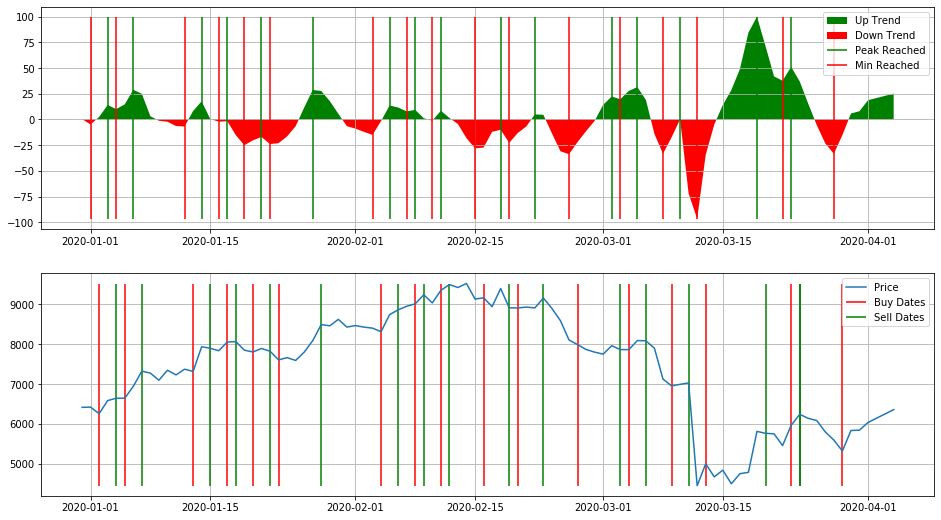

In [526]:
plt.figure(figsize=(16, 9))
ax1 = plt.subplot(2, 1, 1)
plt.fill_between(data.index, 0, grad, where=grad>0, facecolor='green', interpolate=True)
plt.fill_between(data.index, 0, grad, where=grad<=0, facecolor='red', interpolate=True)
plt.vlines(data.index[locs[1] - 1], np.min(grad), np.max(grad), color='g')
plt.vlines(data.index[locs[0] - 1], np.min(grad), np.max(grad), color='r')
plt.legend(['Up Trend', 'Down Trend', 'Peak Reached', 'Min Reached'])
plt.grid()
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(data)
plt.vlines(model_eval['Buy Dates'], np.min(data), np.max(data), color='r')
plt.vlines(model_eval['Sell Dates'], np.min(data), np.max(data), color='g')
plt.legend(['Price', 'Buy Dates', 'Sell Dates'])
plt.grid()
plt.show()

THERE IS CURRENTLY AN POSITION BOUGHT AND TO BE SOLD IN THE FUTURE!


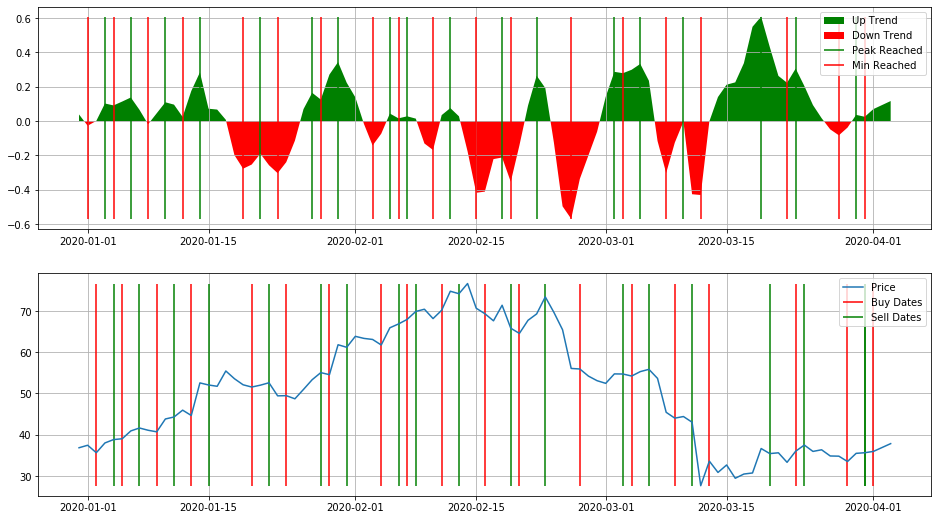

In [517]:
locs_and_grad = price_model(data, values_of_interest=(12, 26, 9), buy_delay=1, grad_return=True)
locs = locs_and_grad[0:2]
grad = locs_and_grad[-1]


plt.figure(figsize=(16, 9))
ax1 = plt.subplot(2, 1, 1)
plt.fill_between(data.index, 0, grad, where=grad>0, facecolor='green', interpolate=True)
plt.fill_between(data.index, 0, grad, where=grad<=0, facecolor='red', interpolate=True)
plt.vlines(data.index[locs[1] - 1], np.min(grad), np.max(grad), color='g')
plt.vlines(data.index[locs[0] - 1], np.min(grad), np.max(grad), color='r')
plt.legend(['Up Trend', 'Down Trend', 'Peak Reached', 'Min Reached'])
plt.grid()
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(data)
plt.vlines(model_eval['Buy Dates'], np.min(data), np.max(data), color='r')
plt.vlines(model_eval['Sell Dates'], np.min(data), np.max(data), color='g')
plt.legend(['Price', 'Buy Dates', 'Sell Dates'])
plt.grid()
plt.show()

In [523]:
data.tail()

Date
2020-03-29    33.507637
2020-03-30    35.488018
2020-03-31    35.640789
2020-04-01    35.955666
2020-04-04    37.404236
Name: Close, dtype: float64